# Using  FER2013 First, condiser LittleVGG for Emotion Detection

### Training Emotion Detector

In [1]:
from __future__ import print_function

import os

from time import sleep

import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, ELU, Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1
from tensorflow.keras.utils import load_img, img_to_array

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from os import listdir
from os.path import isfile, join
import re

In [2]:
cv2.__version__

'4.6.0'

In [3]:
## initializing 

In [4]:
num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 512

train_data_dir = './archive/train/'
validation_data_dir = './archive/test/'

In [5]:


# Let's use some data augmentaiton 
# train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
        rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
print(validation_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [7]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
# model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# # model.add(BatchNormalization())

model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Activation("softmax"))

model.summary()
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(7, activation='softmax'))


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)    

2022-09-23 11:35:19.723204: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-23 11:35:19.723342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training our model

In [18]:
# If you want to train the same model or try other models, go for this

filepath = os.path.join("../emotion_detector_models/charlie_model/initial_weights.h5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]
# if mode == "train":
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
nb_train_samples = 28709
nb_validation_samples = 3589
epochs = 150
model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

# plot_model_history(model_info)
# model.save_weights('model.h5')


/Users/charlielosche/miniforge3/envs/enf_tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/var/folders/tv/w6v8s7sx38q5glg08jvjkmtm0000gn/T/ipykernel_35457/2683267252.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_info = model.fit_generator(


Epoch 1/150


2022-09-22 13:53:00.144049: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-22 13:53:00.571027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 1.9326 - accuracy: 0.2185

2022-09-22 13:53:14.060097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 15s 205ms/step - loss: 1.9326 - accuracy: 0.2185 - val_loss: 1.9190 - val_accuracy: 0.2427
Epoch 2/150
56/56 [==============================] - 11s 194ms/step - loss: 1.9091 - accuracy: 0.2514 - val_loss: 1.9168 - val_accuracy: 0.2441
Epoch 3/150
56/56 [==============================] - 10s 182ms/step - loss: 1.9020 - accuracy: 0.2511 - val_loss: 1.9044 - val_accuracy: 0.2494
Epoch 4/150
56/56 [==============================] - 10s 174ms/step - loss: 1.8956 - accuracy: 0.2535 - val_loss: 1.9039 - val_accuracy: 0.2475
Epoch 5/150
56/56 [==============================] - 10s 172ms/step - loss: 1.8903 - accuracy: 0.2539 - val_loss: 1.8903 - val_accuracy: 0.2497
Epoch 6/150
56/56 [==============================] - 10s 179ms/step - loss: 1.8844 - accuracy: 0.2560 - val_loss: 1.8792 - val_accuracy: 0.2667
Epoch 7/150
56/56 [==============================] - 10s 175ms/step - loss: 1.8795 - accuracy: 0.2574 - val_loss: 1.8788 - val_accuracy: 0.2687
Epoc

Epoch 55/150
56/56 [==============================] - 9s 166ms/step - loss: 1.5992 - accuracy: 0.3833 - val_loss: 1.5166 - val_accuracy: 0.4294
Epoch 56/150
56/56 [==============================] - 10s 169ms/step - loss: 1.6020 - accuracy: 0.3872 - val_loss: 1.5155 - val_accuracy: 0.4238
Epoch 57/150
56/56 [==============================] - 9s 165ms/step - loss: 1.5940 - accuracy: 0.3839 - val_loss: 1.4842 - val_accuracy: 0.4286
Epoch 58/150
56/56 [==============================] - 9s 165ms/step - loss: 1.5934 - accuracy: 0.3856 - val_loss: 1.5118 - val_accuracy: 0.4308
Epoch 59/150
56/56 [==============================] - 10s 169ms/step - loss: 1.5922 - accuracy: 0.3866 - val_loss: 1.4992 - val_accuracy: 0.4464
Epoch 60/150
56/56 [==============================] - 10s 174ms/step - loss: 1.5867 - accuracy: 0.3875 - val_loss: 1.4994 - val_accuracy: 0.4291
Epoch 61/150
56/56 [==============================] - 9s 166ms/step - loss: 1.5849 - accuracy: 0.3893 - val_loss: 1.5071 - val_accura

Epoch 82/150
56/56 [==============================] - 10s 168ms/step - loss: 1.5339 - accuracy: 0.4140 - val_loss: 1.4663 - val_accuracy: 0.4528
Epoch 83/150
56/56 [==============================] - 9s 164ms/step - loss: 1.5337 - accuracy: 0.4162 - val_loss: 1.4404 - val_accuracy: 0.4671
Epoch 84/150
56/56 [==============================] - 9s 163ms/step - loss: 1.5281 - accuracy: 0.4171 - val_loss: 1.4338 - val_accuracy: 0.4674
Epoch 85/150
56/56 [==============================] - 10s 168ms/step - loss: 1.5294 - accuracy: 0.4176 - val_loss: 1.4954 - val_accuracy: 0.4358
Epoch 86/150
56/56 [==============================] - 9s 167ms/step - loss: 1.5300 - accuracy: 0.4199 - val_loss: 1.4579 - val_accuracy: 0.4609
Epoch 87/150
56/56 [==============================] - 10s 168ms/step - loss: 1.5213 - accuracy: 0.4226 - val_loss: 1.4473 - val_accuracy: 0.4654
Epoch 88/150
56/56 [==============================] - 10s 175ms/step - loss: 1.5218 - accuracy: 0.4198 - val_loss: 1.4481 - val_accur

Epoch 109/150
56/56 [==============================] - 10s 170ms/step - loss: 1.4874 - accuracy: 0.4361 - val_loss: 1.4021 - val_accuracy: 0.4888
Epoch 110/150
56/56 [==============================] - 9s 167ms/step - loss: 1.4827 - accuracy: 0.4424 - val_loss: 1.4264 - val_accuracy: 0.4612
Epoch 111/150
56/56 [==============================] - 9s 167ms/step - loss: 1.4781 - accuracy: 0.4428 - val_loss: 1.3938 - val_accuracy: 0.4897
Epoch 112/150
56/56 [==============================] - 9s 164ms/step - loss: 1.4836 - accuracy: 0.4403 - val_loss: 1.3862 - val_accuracy: 0.4894
Epoch 113/150
56/56 [==============================] - 9s 163ms/step - loss: 1.4821 - accuracy: 0.4398 - val_loss: 1.3921 - val_accuracy: 0.4860
Epoch 114/150
56/56 [==============================] - 9s 163ms/step - loss: 1.4792 - accuracy: 0.4413 - val_loss: 1.3933 - val_accuracy: 0.4944
Epoch 115/150
56/56 [==============================] - 9s 167ms/step - loss: 1.4798 - accuracy: 0.4419 - val_loss: 1.3858 - val_a

Epoch 136/150
56/56 [==============================] - 9s 165ms/step - loss: 1.4470 - accuracy: 0.4509 - val_loss: 1.3601 - val_accuracy: 0.5011
Epoch 137/150
56/56 [==============================] - 10s 170ms/step - loss: 1.4460 - accuracy: 0.4546 - val_loss: 1.3472 - val_accuracy: 0.5131
Epoch 138/150
56/56 [==============================] - 10s 178ms/step - loss: 1.4495 - accuracy: 0.4541 - val_loss: 1.3655 - val_accuracy: 0.4967
Epoch 139/150
56/56 [==============================] - 9s 165ms/step - loss: 1.4454 - accuracy: 0.4572 - val_loss: 1.3908 - val_accuracy: 0.4749
Epoch 140/150
56/56 [==============================] - 10s 171ms/step - loss: 1.4430 - accuracy: 0.4577 - val_loss: 1.3692 - val_accuracy: 0.4958
Epoch 141/150
56/56 [==============================] - 9s 165ms/step - loss: 1.4465 - accuracy: 0.4548 - val_loss: 1.3884 - val_accuracy: 0.4838
Epoch 142/150
56/56 [==============================] - 9s 166ms/step - loss: 1.4410 - accuracy: 0.4588 - val_loss: 1.3667 - val

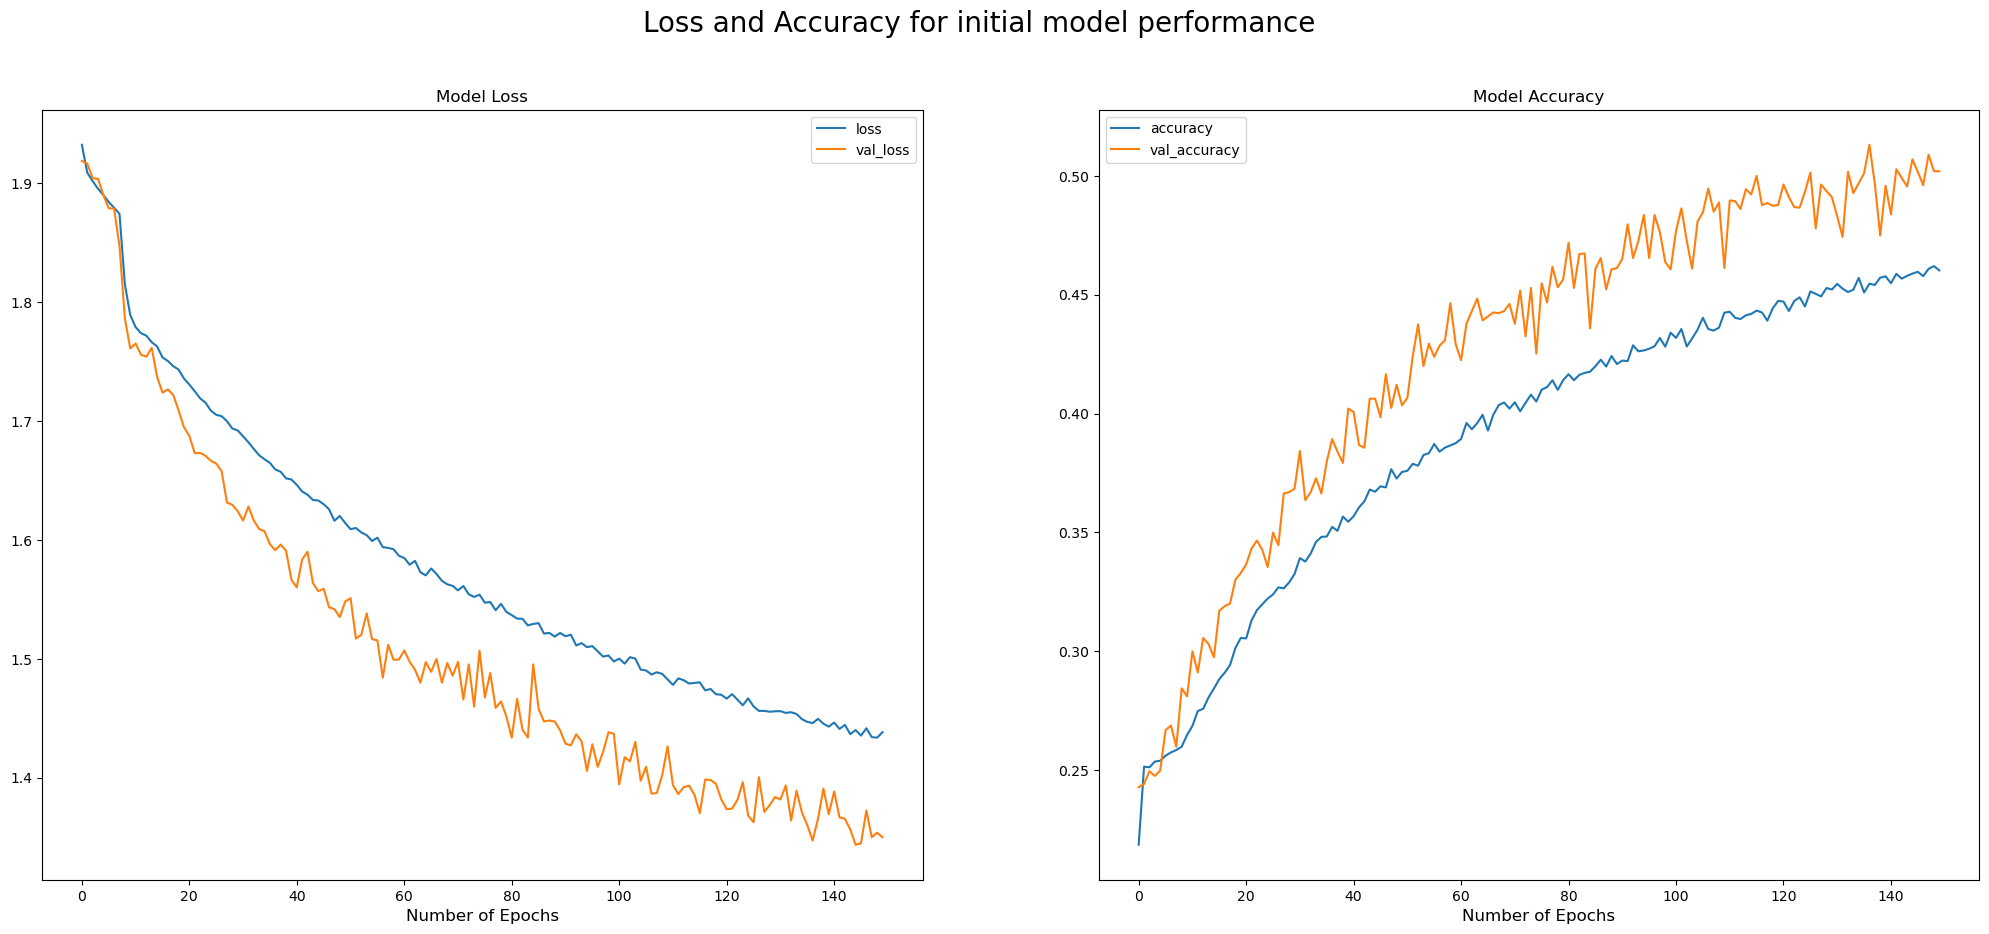

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sigmoid_loss = model_info.history['loss']
sigmoid_accuracy = model_info.history['accuracy']
val_sigmoid_loss = model_info.history['val_loss']
val_sigmoid_accuracy = model_info.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=model_info.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=model_info.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=model_info.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=model_info.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy for initial model performance', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


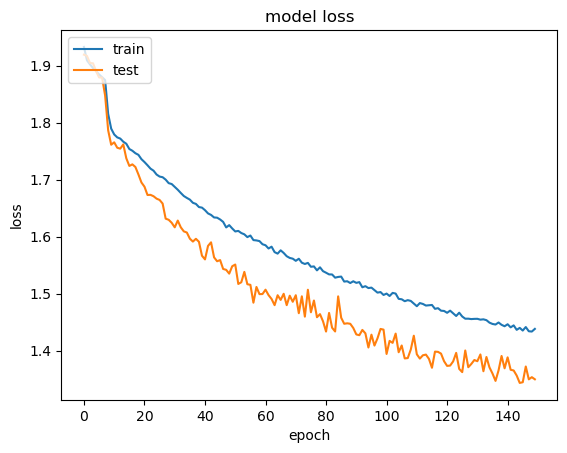

In [23]:
print(model_info.history.keys())

plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# Save previous model weights
model.save_weights('../emotion_detector_models/charlie_model/initial_weights.h5')


In [26]:
#Apply initial model weights to the model to transfer learning from initial run
model.load_weights('../emotion_detector_models/charlie_model/initial_weights.h5')

In [27]:
model_info2 = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)


/var/folders/tv/w6v8s7sx38q5glg08jvjkmtm0000gn/T/ipykernel_35457/2965488548.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_info2 = model.fit_generator(


Epoch 1/150
56/56 [==============================] - 13s 215ms/step - loss: 1.4345 - accuracy: 0.4603 - val_loss: 1.3835 - val_accuracy: 0.4933
Epoch 2/150
56/56 [==============================] - 12s 207ms/step - loss: 1.4240 - accuracy: 0.4651 - val_loss: 1.3390 - val_accuracy: 0.5229
Epoch 3/150
56/56 [==============================] - 12s 207ms/step - loss: 1.4299 - accuracy: 0.4635 - val_loss: 1.3803 - val_accuracy: 0.4958
Epoch 4/150
56/56 [==============================] - 11s 197ms/step - loss: 1.4283 - accuracy: 0.4655 - val_loss: 1.3528 - val_accuracy: 0.5112
Epoch 5/150
56/56 [==============================] - 11s 199ms/step - loss: 1.4259 - accuracy: 0.4677 - val_loss: 1.3496 - val_accuracy: 0.4927
Epoch 6/150
56/56 [==============================] - 11s 194ms/step - loss: 1.4273 - accuracy: 0.4643 - val_loss: 1.3430 - val_accuracy: 0.5081
Epoch 7/150
56/56 [==============================] - 11s 203ms/step - loss: 1.4245 - accuracy: 0.4687 - val_loss: 1.3308 - val_accuracy:

Epoch 28/150
56/56 [==============================] - 11s 192ms/step - loss: 1.4053 - accuracy: 0.4737 - val_loss: 1.3591 - val_accuracy: 0.5031
Epoch 29/150
56/56 [==============================] - 11s 191ms/step - loss: 1.4030 - accuracy: 0.4781 - val_loss: 1.3231 - val_accuracy: 0.5098
Epoch 30/150
56/56 [==============================] - 9s 166ms/step - loss: 1.4027 - accuracy: 0.4750 - val_loss: 1.3065 - val_accuracy: 0.5299
Epoch 31/150
56/56 [==============================] - 9s 157ms/step - loss: 1.4020 - accuracy: 0.4776 - val_loss: 1.3474 - val_accuracy: 0.5086
Epoch 32/150
56/56 [==============================] - 9s 153ms/step - loss: 1.4016 - accuracy: 0.4763 - val_loss: 1.3283 - val_accuracy: 0.5218
Epoch 33/150
56/56 [==============================] - 8s 150ms/step - loss: 1.4011 - accuracy: 0.4744 - val_loss: 1.3202 - val_accuracy: 0.5237
Epoch 34/150
56/56 [==============================] - 8s 145ms/step - loss: 1.3993 - accuracy: 0.4760 - val_loss: 1.3111 - val_accurac

Epoch 55/150
56/56 [==============================] - 8s 148ms/step - loss: 1.3806 - accuracy: 0.4877 - val_loss: 1.2858 - val_accuracy: 0.5335
Epoch 56/150
56/56 [==============================] - 8s 148ms/step - loss: 1.3804 - accuracy: 0.4852 - val_loss: 1.2970 - val_accuracy: 0.5215
Epoch 57/150
56/56 [==============================] - 9s 154ms/step - loss: 1.3802 - accuracy: 0.4869 - val_loss: 1.3101 - val_accuracy: 0.5285
Epoch 58/150
56/56 [==============================] - 8s 147ms/step - loss: 1.3755 - accuracy: 0.4870 - val_loss: 1.3104 - val_accuracy: 0.5218
Epoch 59/150
56/56 [==============================] - 8s 151ms/step - loss: 1.3761 - accuracy: 0.4907 - val_loss: 1.3111 - val_accuracy: 0.5257
Epoch 60/150
56/56 [==============================] - 8s 146ms/step - loss: 1.3748 - accuracy: 0.4917 - val_loss: 1.3295 - val_accuracy: 0.5271
Epoch 61/150
56/56 [==============================] - 8s 148ms/step - loss: 1.3778 - accuracy: 0.4871 - val_loss: 1.3096 - val_accuracy:

Epoch 82/150
56/56 [==============================] - 8s 147ms/step - loss: 1.3597 - accuracy: 0.4956 - val_loss: 1.2982 - val_accuracy: 0.5206
Epoch 83/150
56/56 [==============================] - 9s 159ms/step - loss: 1.3596 - accuracy: 0.4964 - val_loss: 1.3036 - val_accuracy: 0.5324
Epoch 84/150
56/56 [==============================] - 9s 151ms/step - loss: 1.3614 - accuracy: 0.4942 - val_loss: 1.3308 - val_accuracy: 0.5145
Epoch 85/150
56/56 [==============================] - 8s 150ms/step - loss: 1.3600 - accuracy: 0.4965 - val_loss: 1.2980 - val_accuracy: 0.5273
Epoch 86/150
56/56 [==============================] - 8s 149ms/step - loss: 1.3566 - accuracy: 0.4949 - val_loss: 1.2964 - val_accuracy: 0.5287
Epoch 87/150
56/56 [==============================] - 8s 146ms/step - loss: 1.3556 - accuracy: 0.4952 - val_loss: 1.2703 - val_accuracy: 0.5416
Epoch 88/150
56/56 [==============================] - 8s 145ms/step - loss: 1.3548 - accuracy: 0.4985 - val_loss: 1.3138 - val_accuracy:

Epoch 109/150
56/56 [==============================] - 8s 140ms/step - loss: 1.3476 - accuracy: 0.5036 - val_loss: 1.2915 - val_accuracy: 0.5360
Epoch 110/150
56/56 [==============================] - 8s 141ms/step - loss: 1.3379 - accuracy: 0.5053 - val_loss: 1.2969 - val_accuracy: 0.5332
Epoch 111/150
56/56 [==============================] - 8s 143ms/step - loss: 1.3459 - accuracy: 0.5030 - val_loss: 1.2901 - val_accuracy: 0.5204
Epoch 112/150
56/56 [==============================] - 8s 142ms/step - loss: 1.3390 - accuracy: 0.5037 - val_loss: 1.2644 - val_accuracy: 0.5405
Epoch 113/150
56/56 [==============================] - 8s 141ms/step - loss: 1.3433 - accuracy: 0.5027 - val_loss: 1.2896 - val_accuracy: 0.5271
Epoch 114/150
56/56 [==============================] - 8s 140ms/step - loss: 1.3382 - accuracy: 0.5034 - val_loss: 1.2688 - val_accuracy: 0.5304
Epoch 115/150
56/56 [==============================] - 8s 140ms/step - loss: 1.3383 - accuracy: 0.5009 - val_loss: 1.2743 - val_ac

Epoch 136/150
56/56 [==============================] - 8s 139ms/step - loss: 1.3339 - accuracy: 0.5085 - val_loss: 1.2663 - val_accuracy: 0.5340
Epoch 137/150
56/56 [==============================] - 8s 140ms/step - loss: 1.3322 - accuracy: 0.5083 - val_loss: 1.2551 - val_accuracy: 0.5427
Epoch 138/150
56/56 [==============================] - 8s 140ms/step - loss: 1.3265 - accuracy: 0.5115 - val_loss: 1.2900 - val_accuracy: 0.5257
Epoch 139/150
56/56 [==============================] - 8s 143ms/step - loss: 1.3249 - accuracy: 0.5098 - val_loss: 1.2547 - val_accuracy: 0.5407
Epoch 140/150
56/56 [==============================] - 8s 142ms/step - loss: 1.3220 - accuracy: 0.5099 - val_loss: 1.2592 - val_accuracy: 0.5377
Epoch 141/150
56/56 [==============================] - 8s 141ms/step - loss: 1.3237 - accuracy: 0.5098 - val_loss: 1.2750 - val_accuracy: 0.5416
Epoch 142/150
56/56 [==============================] - 8s 140ms/step - loss: 1.3171 - accuracy: 0.5150 - val_loss: 1.2666 - val_ac

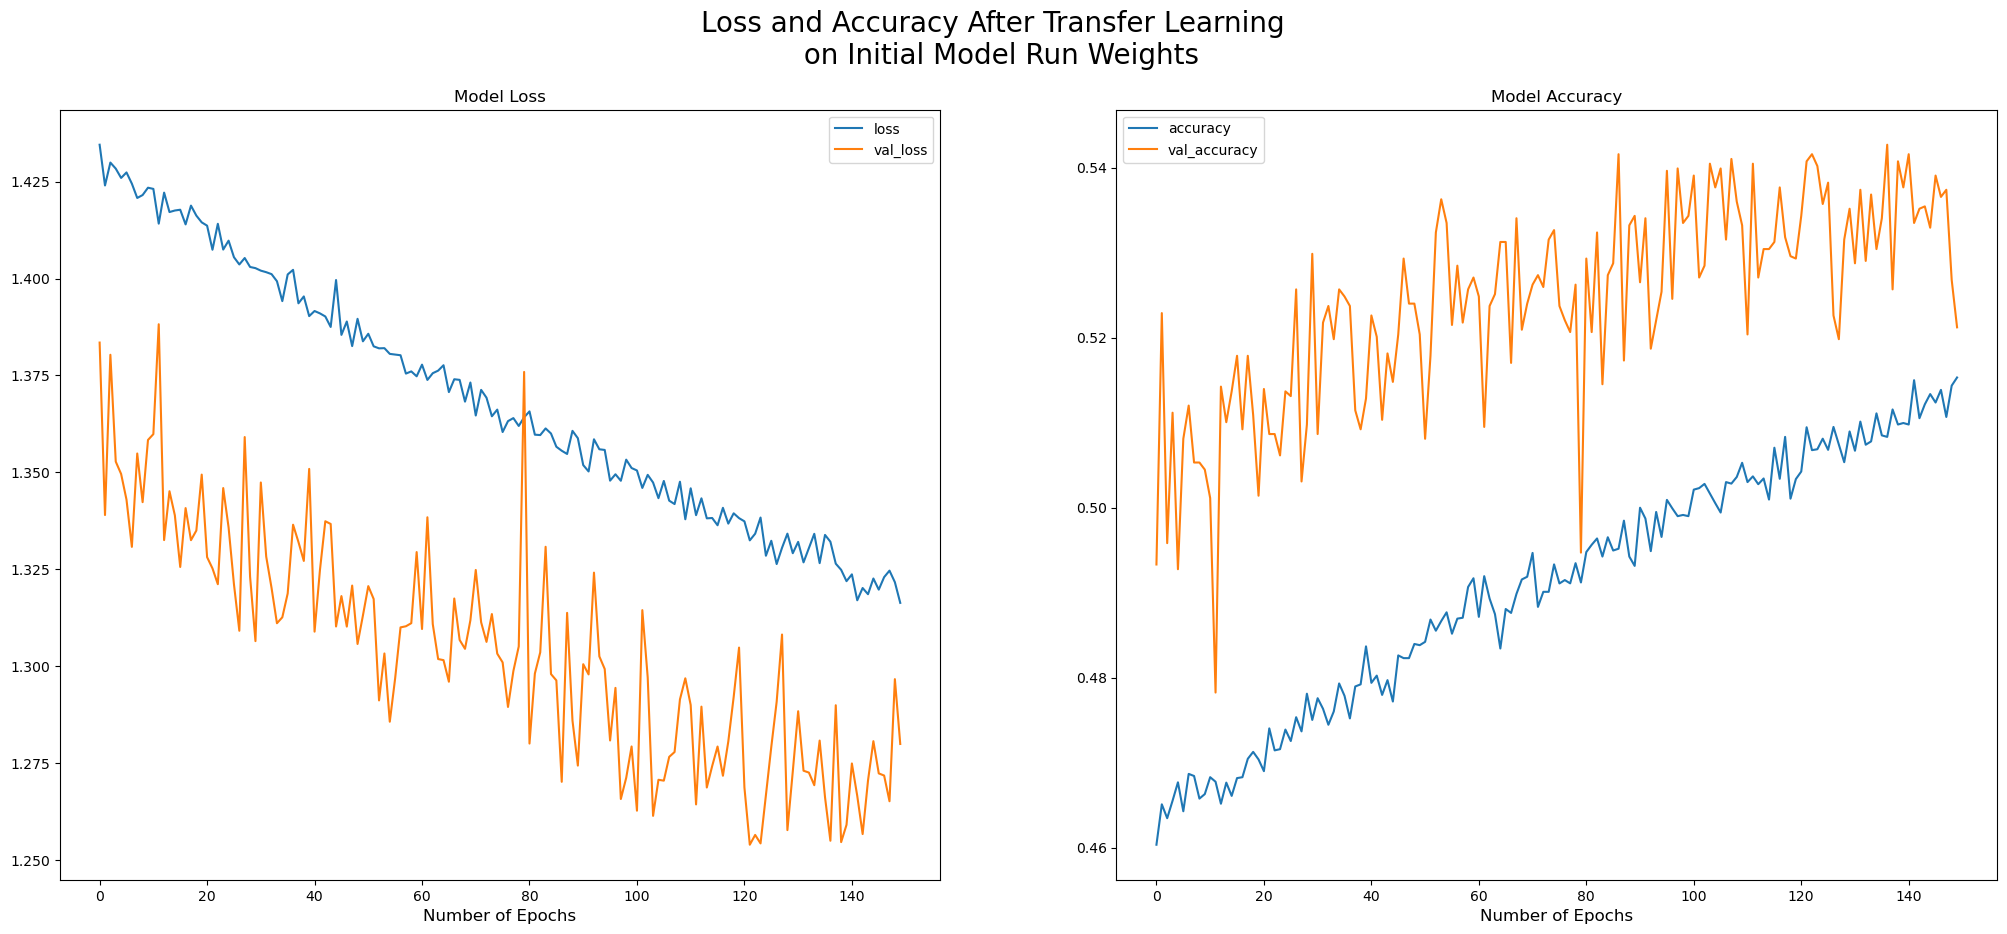

In [28]:
sigmoid_loss = model_info2.history['loss']
sigmoid_accuracy = model_info2.history['accuracy']
val_sigmoid_loss = model_info2.history['val_loss']
val_sigmoid_accuracy = model_info2.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=model_info2.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=model_info2.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=model_info2.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=model_info2.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy After Transfer Learning \n on Initial Model Run Weights', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

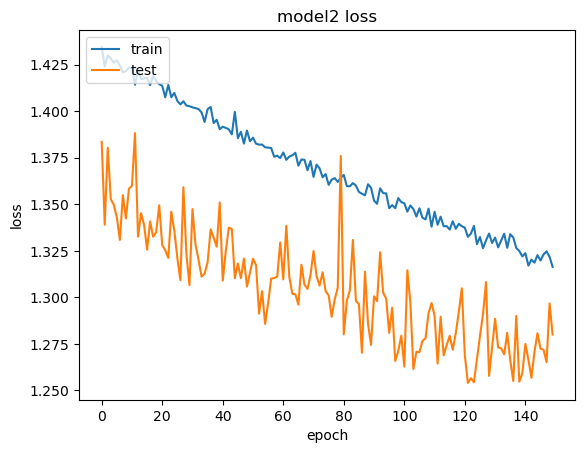

In [30]:
plt.plot(model_info2.history['loss'])
plt.plot(model_info2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Commenting out original model loading

In [8]:
# model.load_weights(os.path.join("./emotion_detector_models/model_29.hdf5"))
# # history = model.fit_generator(
# #     train_generator,
# #     steps_per_epoch = nb_train_samples // batch_size,
# #     epochs = epochs,
# #     callbacks = callbacks,
# #     validation_data = validation_generator,
# #     validation_steps = nb_validation_samples // batch_size)

In [31]:

# Found 28709 images belonging to 7 classes.
# Found 3589 images belonging to 7 classes.


In [33]:


# nb_train_samples = 28273
# nb_validation_samples = 3534
nb_train_samples = 28709
nb_validation_samples = 3589

# We need to recreate our validation generator with shuffle = false
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)



Found 7178 images belonging to 7 classes.


In [37]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


15/15 [==============================] - 1s 95ms/step


In [38]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [39]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [40]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[ 391    0  104  108  127  171   57]
 [  54    0   13   11    8   23    2]
 [ 149    0  213  120  140  236  166]
 [  63    0   58 1484   74   46   49]
 [  87    0  101  151  627  232   35]
 [ 149    0  145  171  233  518   31]
 [  27    0   86   61   32   20  605]]
Classification Report
              precision    recall  f1-score   support

       angry       0.42      0.41      0.42       958
     disgust       0.00      0.00      0.00       111
        fear       0.30      0.21      0.24      1024
       happy       0.70      0.84      0.76      1774
     neutral       0.51      0.51      0.51      1233
         sad       0.42      0.42      0.42      1247
    surprise       0.64      0.73      0.68       831

    accuracy                           0.53      7178
   macro avg       0.43      0.44      0.43      7178
weighted avg       0.51      0.53      0.52      7178



/Users/charlielosche/miniforge3/envs/enf_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/enf_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/enf_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

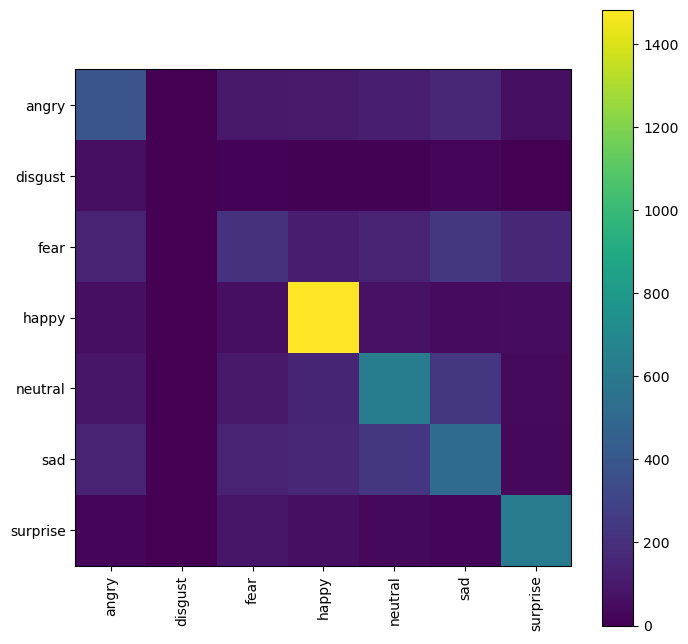

In [41]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

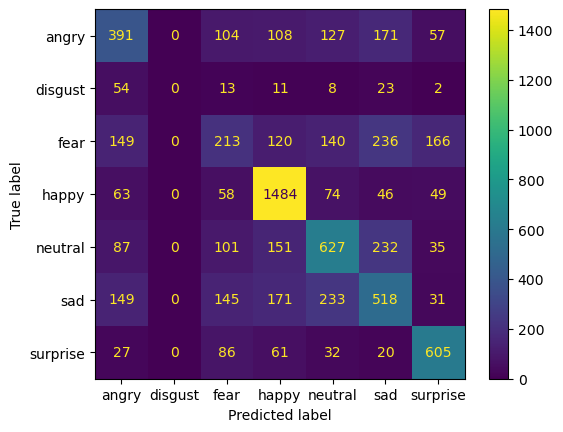

In [46]:

cnf_matrix = confusion_matrix(y_true=validation_generator.classes, y_pred=y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classes)

disp.plot()

plt.show();

In [59]:
# saving model

model.save('../emotion_detector_models/charlie_model/final_model.h5')

### Loading our saved model

In [7]:
classifier = load_model('../emotion_detector_models/charlie_model/final_model.h5')

Metal device set to: Apple M1 Pro


2022-09-23 12:13:10.968084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-23 12:13:10.968339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
classifier

## Attempting to replicate above confusion matrix with saved model

In [9]:


# nb_train_samples = 28273
# nb_validation_samples = 3534
nb_train_samples = 28709
nb_validation_samples = 3589

# We need to recreate our validation generator with shuffle = false
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)



Found 7178 images belonging to 7 classes.


In [10]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = classifier.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


 1/15 [=>............................] - ETA: 1s

2022-09-23 12:13:16.222117: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-23 12:13:16.266400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 71ms/step


In [11]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [12]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [13]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[ 391    0  104  108  127  171   57]
 [  54    0   13   11    8   23    2]
 [ 149    0  213  120  140  236  166]
 [  63    0   58 1484   74   46   49]
 [  87    0  101  151  627  232   35]
 [ 149    0  145  171  233  518   31]
 [  27    0   86   61   32   20  605]]
Classification Report
              precision    recall  f1-score   support

       angry       0.42      0.41      0.42       958
     disgust       0.00      0.00      0.00       111
        fear       0.30      0.21      0.24      1024
       happy       0.70      0.84      0.76      1774
     neutral       0.51      0.51      0.51      1233
         sad       0.42      0.42      0.42      1247
    surprise       0.64      0.73      0.68       831

    accuracy                           0.53      7178
   macro avg       0.43      0.44      0.43      7178
weighted avg       0.51      0.53      0.52      7178



/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

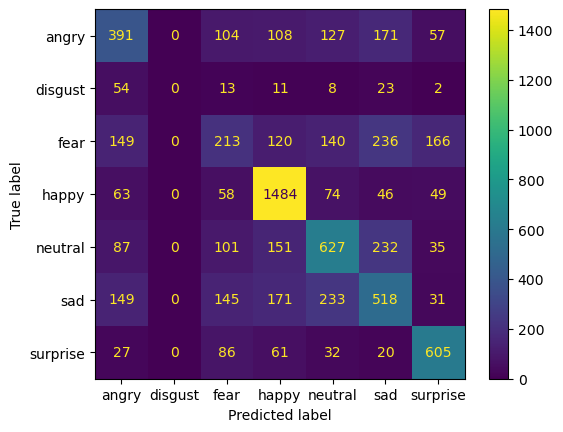

In [14]:

cnf_matrix = confusion_matrix(y_true=validation_generator.classes, y_pred=y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classes)

disp.plot()

plt.show();

# Try and figure out where to replace with classifier

### Get our class labels

In [15]:
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 7178 images belonging to 7 classes.
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


### Let's test on some of validation images

In [16]:
print(cv2.__version__)

4.6.0


In [17]:

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "Predicted - "+ pred, (20, 60) , cv2.FONT_HERSHEY_COMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "True - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0), 2)
    plt.imshow(expanded_image)
    plt.show()


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return load_img(final_path, target_size = (img_width, img_height),color_mode="grayscale"), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48


In [18]:
# Try to load an imgage using above function
path = './archive/test/' 

img, final_path, true_label = getRandomImage(path, img_width, img_height)

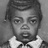

In [19]:
img

In [20]:
final_path

'./archive/test/neutral/PublicTest_29091719.jpg'

In [21]:
true_label

'neutral'

In [22]:
## Comenting out new compiler to avoid retraining saved model

In [23]:
# # We use a very small learning rate 
# model.compile(loss = 'categorical_crossentropy',
#               optimizer = RMSprop(learning_rate=0.001),
#               metrics = ['accuracy'])


In [24]:
files = []
predictions = []
true_labels = []

# TRYING TO UPDATE CODE

In [25]:
# predicting images
for i in range(0, 10):
    path = './archive/test/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    preds = classifier.predict(images, batch_size = 10)
    classes = np.argmax(preds,axis=1)
    predictions.append(classes)

1/1 [==============================] - 0s 8ms/step


2022-09-23 12:13:47.745606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 8ms/step


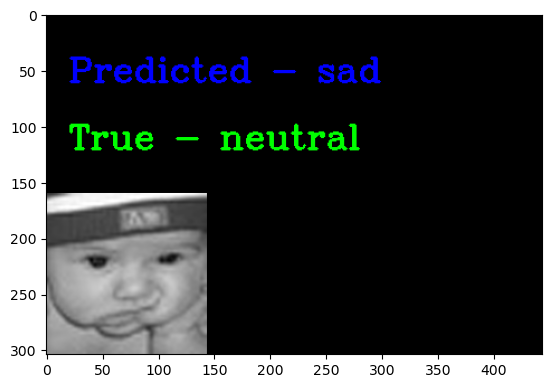

In [26]:
# Attempt generating one image first and it's class
%matplotlib inline


image = cv2.imread((files[0]))
image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
draw_test("Prediction", class_labels[predictions[0][0]], image, true_labels[0])

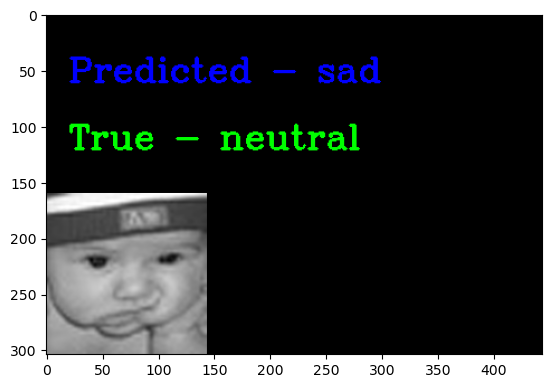

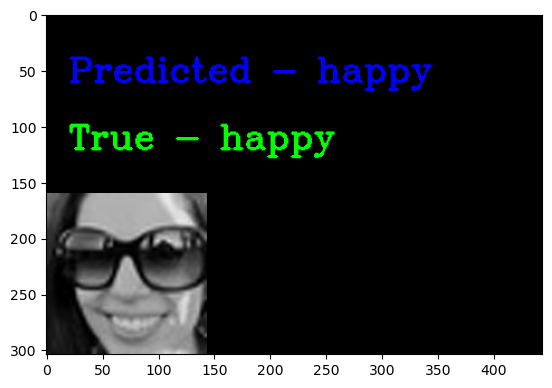

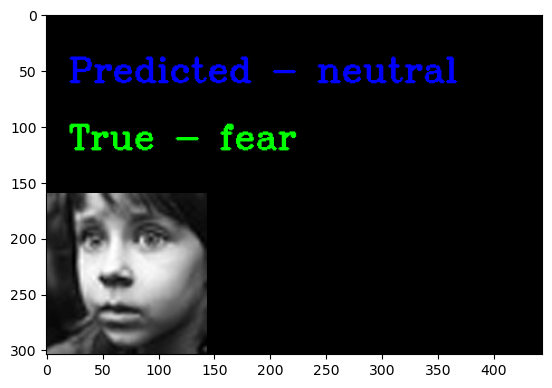

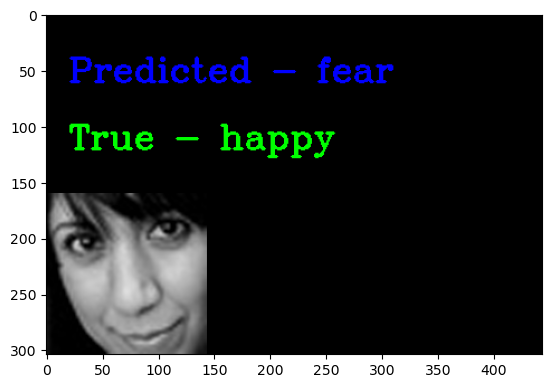

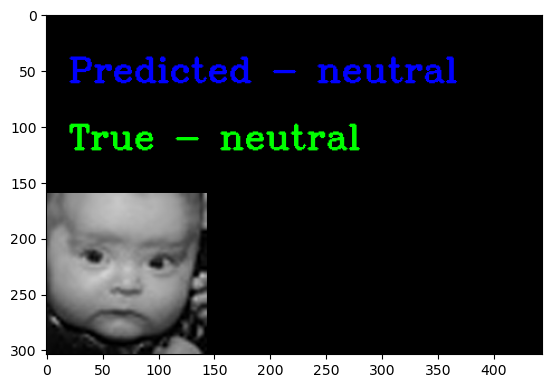

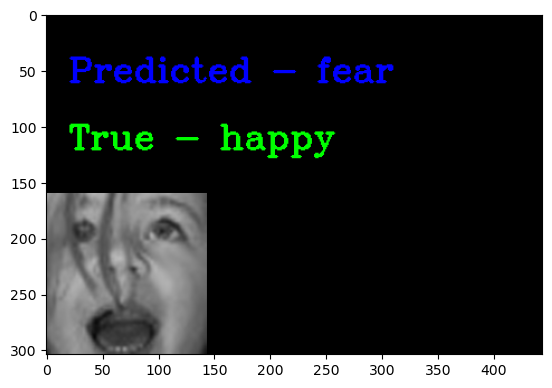

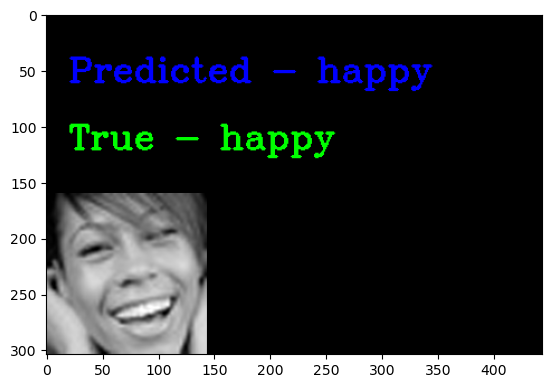

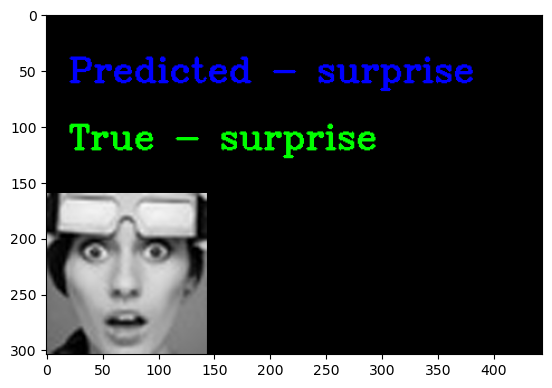

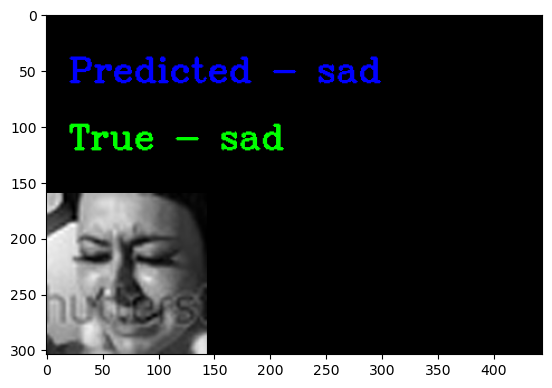

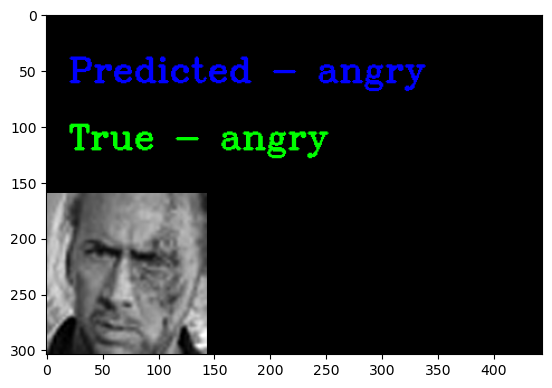

In [27]:
%matplotlib inline

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])

### Test on a single image

In [28]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [32]:
def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if np.array_equal(faces,()):
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

1/1 [==============================] - 0s 10ms/step


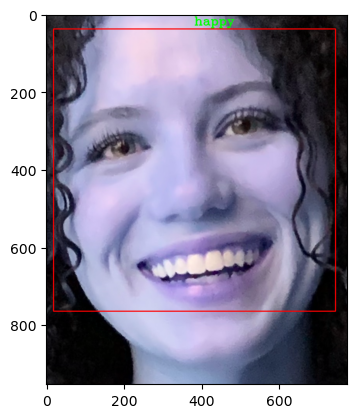

In [33]:
%matplotlib inline

img = cv2.imread("../test_images/Paige2_Happy.jpeg")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0), 2)
    
    #Show the image with matplotlib
    plt.imshow(image)
    plt.show()

### Let's try this on our webcam


In [35]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if np.array_equal(faces,()):
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


In [37]:
cap.release()
cv2.destroyAllWindows()      